<div style="width: 100%; clear: both; font-family: Verdana;">
<div style="float: left; width: 50%;font-family: Verdana;">
<img src="https://github.com/Eligoze/att-rci-internal/blob/qa/RCI_DataAnalysis/eda/doc/att-logo1.png" align="left">
</div>
<div style="float: right; width: 200%;">
<p style="margin: 0; padding-top: 20px; text-align:right;color:rgb(193, 38, 184)"><strong>Axity - AT&T.
    Ciclo de vida de elementos de inventario</strong></p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

# Exploratory Data Analysis
## Ciclo de vida de elementos de inventario.
### Axity - AT&T.

## Descripción
Analizaremos los datos de las fuentes de inventarios de AT&T con un tratamiento estadístico descriptivo para hacer el tracking del ciclo de vida de los elementos de red. Se creará un EDA enfocado a la salida de almacén. Serán documentados los catálogos propuestos junto a su respectivo tratamiento de datos. La fuente que corresponde a este análisis es:

* **Gestor Ciena**

Primero cargamos las librerías necesarias.

#### Conectando al Datalake

In [1]:
import os
os.environ['JAVA_HOME'] = '/usr/java/jdk1.8.0_162'
os.environ['SPARK_HOME'] = '/opt/cloudera/parcels/CDH-6.2.0-1.cdh6.2.0.p0.967373/lib/spark'
import findspark
findspark.init()
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql import HiveContext

In [2]:
conf = SparkConf().setAppName('Segregacion')  \
    .setMaster('yarn').set("spark.yarn.queue","root.eda")
spark = SparkSession.builder.config(conf=conf).getOrCreate()
sc = spark.sparkContext
sqlContext = HiveContext(sc)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import re

from pyspark.sql.functions import udf ,col
from pyspark.sql.types import IntegerType,StringType

%matplotlib inline

from bokeh.io import show, output_notebook, output_file 
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource
from bokeh.palettes import Category20_11, Category20c_20, Category10_5,Category10_6, Category20_20, Plasma256,Category20c_18
output_notebook()

Loading BokehJS ...

### Recolección de los datos: 

*IMPORTANTE*: Si se requieren ver datos de otro periódo, se debe cambiar los filtros ```year = <año-a-ejecutar>```, ```month = <mes-a-ejecutar>```, ```day = <día-a-ejecutar>``` de las tablas en la siguiente celda:

Se crea el dataframe de spark

In [4]:
df_load =spark.sql("SELECT *, serial_number as serie FROM default.tx_ciena").cache()#.toPandas() 

<div style="width: 100%; clear: both; font-family: Verdana;">
    <p> 
    Creamos una funcion para el tratamiento de datos en spark el cual contiene la reglas definidas para la columna serie:
    </p>
</div>

In [5]:
def validate_rule(string):
    
    search_list=[" ",'!','%','$',"<",">","^",'¡',"+","N/A",u'¿','~','#','Ñ',"Ã","Åƒ","Ã‹","Ã³",'Ë','*','?',"ILEGIBLE", "VICIBLE","VISIBLE","INCOMPLETO"]
    str_temp = string.encode('utf-8')
    if str_temp.upper() == "BORRADO":
      return 1
    elif len(str_temp) < 6:
      return 1
    elif any(ext in str_temp.upper()for ext in search_list):
      return 1
    else:
      return 0

<div style="width: 100%; clear: both; font-family: Verdana;">
    <p> 
    Se crea un udf en spark sobre la funcion ya creada 
    </p>
</div>

In [6]:
validate_rule_udf = udf(validate_rule, IntegerType())

<div style="width: 100%; clear: both; font-family: Verdana;">
    <p> 
    Se le agrega una nueva columna al dataframe de spark; la nueva columna es la validacion de la columna serie con respecto al udf que creamos.
    </p>
</div>

In [7]:
df_serie = df_load.withColumn("serie_cleaned",validate_rule_udf(col("serie"))).cache()

<div style="width: 100%; clear: both; font-family: Verdana;">
    <p> 
    Se convierte el dataframe de spark a un dataframe de pandas 
    </p>
</div>

In [8]:
df = df_serie.toPandas()

Hemos recolectado los campos a analizar de la fuente **tx_ciena**.

## Características de los elementos de red en Ciena
Una muestra de la fuente Ciena

In [9]:
df.drop(columns=['serial_number'],inplace=True)
df.head(5)

,system_name,ne_type,component,component_subtype,clei_code,part_number,manufacture_date,hardware_version,firmware_version,software_version,...,sourceid,registry_state,datasetname,timestamp,transaction_status,year,month,day,serie,serie_cleaned
0,CAGSNFO0027OTN1401,6500-14,10-ene,100GOCLD,WOTRCPLFAA,NTK539UD,2015-44,8,--,REL1121Z.AW,...,Gestores-CIENA,2019:10:26:13:32:46,tx_ciena,20191126,insert,2019,7,15,NNTMRT0DE0K6,0
1,CAGSNFO0027OTN1401,6500-14,oct-13,PKTOTN,WOTRC9SFAB,NTK667AA,2014-38,5,--,REL1121Z.AW,...,Gestores-CIENA,2019:10:26:13:32:46,tx_ciena,20191126,insert,2019,7,15,NNTMRT08RV55,0
2,CAGSNFO0027OTN1401,6500-14,10-13-1,P10GSOEL,WOTRANAKAC,NTTP84BA,--,--,--,--,...,Gestores-CIENA,2019:10:26:13:32:46,tx_ciena,20191126,insert,2019,7,15,FNSRMYUUF12F2,0
3,CAGSNFO0027OTN1401,6500-14,10-13-2,P10GSOEL,WOTRCD2FAA,NTTP84AA,--,--,--,--,...,Gestores-CIENA,2019:10:26:13:32:46,tx_ciena,20191126,insert,2019,7,15,EXLGCN5713860683,0
4,CAGSNFO0027OTN1401,6500-14,10-13-3,P10GSOEL,WOTRANAKAC,NTTP84BA,--,--,--,--,...,Gestores-CIENA,2019:10:26:13:32:46,tx_ciena,20191126,insert,2019,7,15,FNSRMYUUF12EK,0


### Diccionario de datos.
A continuación se enlistan los campos de la fuente con una breve descripción de negocio.  

* **system_name**: Nombre del sistema.
* **ne_type**: Tipo de elemento de red.
* **component**: Nombre del componente.
* **component_subtype**: Tipo de componente.
* **clei_code**: Código único DEFINIR.
* **part_number**:Código número de parte.
* **manufacture_date**: Fecha de manufactura.
* **hardware_version**: Versión Hardware.
* **firmware_version**: Versión firmware.
* **software_version**: Versión Software.
* **operational_status**: Definición del negocio.
* **model_id**: Clave del modelo.
* **accuracy_date**: Definición del negocio.
* **wavelength**: Longitud de onda.
* **frequency**: Frecuencia de onda.
* **channel_number**: Definición del negocio.
* **serie**: Código de trazabilidad que da el proveedor.
* **serie_cleaned**: Campo agregado por la función Spark, es una bandera booleana que señala la consistencia de la serie.
* **filedate**: Fecha de carga del archivo.
* **filename**: Nombre del archivo cargado.
* **hash_id**: Identificador único Hash.
* **source_id**: Fuente de archivo.
* **registry_state**: Timestamp de carga.
* **datasetname**: Nombre del ....
* **timestamp**: Fecha de carga.
* **transaction_status**: Estatus de carga.
* **year**: Año del archivo.
* **month**: Mes del archivo.
* **day**: Día del archivo.

### 2. Descripción de las fuentes.
En este apartado se hará una descripción a detalle de las fuentes para una mejor comprensión de los datos. Por cada fuente se mostrarán los tipos de datos, tamaño de la fuente, es decir, su dimensionalidad y una estadística descriptiva, en ese orden.

In [10]:
campos=df.columns
print('Columnas de la fuente Ciena son: ',list(campos))
pd.DataFrame(df.dtypes,columns=['Tipo de objeto SOURCE'])

('Columnas de la fuente Ciena son: ', ['system_name', 'ne_type', 'component', 'component_subtype', 'clei_code', 'part_number', 'manufacture_date', 'hardware_version', 'firmware_version', 'software_version', 'operational_status', 'model_id', 'accuracy_date', 'wavelength', 'frequency', 'channel_number', 'filedate', 'filename', 'hash_id', 'sourceid', 'registry_state', 'datasetname', 'timestamp', 'transaction_status', 'year', 'month', 'day', 'serie', 'serie_cleaned'])


,Tipo de objeto SOURCE
system_name,object
ne_type,object
component,object
component_subtype,object
clei_code,object
part_number,object
manufacture_date,object
hardware_version,object
firmware_version,object
software_version,object


In [11]:
print('renglones = ',df.shape[0],' columnas = ',df.shape[1])

('renglones = ', 3785, ' columnas = ', 29)


In [12]:
#Pasamos las columnas que queremos ver en nuestro describe:
NOrelevantes=['filedate', 'filename', 'hash_id', 'sourceid',
              'registry_state', 'datasetname', 'timestamp',
              'transaction_status', 'year', 'month', 'day']
relevantes=[v for v in df.columns if v not in NOrelevantes]

df[relevantes].describe(include='all')

,system_name,ne_type,component,component_subtype,clei_code,part_number,manufacture_date,hardware_version,firmware_version,software_version,operational_status,model_id,accuracy_date,wavelength,frequency,channel_number,serie,serie_cleaned
count,3785,3785,3785,3785,3785,3785,3785,3785,3785,3785,3785,3785,3785,3785,3785,3785,3785,3785.000000
unique,130,4,578,26,56,54,180,14,1,5,3,1,2,1,1,1,3775,NaN
top,CMDFMEX9226OTN3201,6500-14,1-PWR1,P10GSOEL,WOTRANAKAC,NTTP84BA,--,--,--,--,IS,--,Current,--,--,--,--,NaN
freq,115,1781,80,932,843,843,1475,1485,3785,2362,3782,3785,3769,3785,3785,3785,10,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002642
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.051339
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000


#### Haremos anotaciones sobre lo que se puede observar de la tabla describe:

* Sobre el campo colocado *serie_describe* podemos ver que la mayoría de registros del campo *serie* se encuentran en mal estado.
* Los nulos son registrados como "**--**". Habrá que darles formato de NaN.
* Se observo anteriormente en el head que el campo *component* los datos han tomado formato de fecha. Esto será marcado como data error.
* Según lo que se puede observar, serán explorados para propuesta de catálogos los campos: **ne_type, hardware_version, software_version** y **operational_status**.

#### Se proponen catálogos derivados de la fuente Ciena con los siguientes campos:
    
* **ne_type**: Tipo de elemento de red.
* **hardware_version**: Versión Hardware.
* **software_version**: Versión Software.
* **operational_status**: DESCRIPCIÓN NEGOCIO.

Estos catálogos nos ayudarán a mapear todos los diferentes proyectos que existen en los cuales hay un activo.


### 3. Exploración de los datos.
De acuerdo al análisis anterior, procedemos a hacer una exploración de los datos con gráficas, de manera particular nos enfocaremos en los catálogos.

#### Para empezar, se hará una limpieza general a los datos:

In [13]:
df.replace('null',np.NaN,inplace=True)
df.replace('NA',np.NaN,inplace=True)
df.replace(u'--',np.NaN,inplace=True)
#Se puede hacer más y por columna en caso de ser necesario

### Primer catálogo: *ne_type*

Empezaremos con el catálogo de **ne_type**.   
Se harán charts para visualizar la distribución de las categorías. Este catálogo será llamado después en el apartado de catálogos. Nuestra intención por el momento es simplemente explorar los datos.

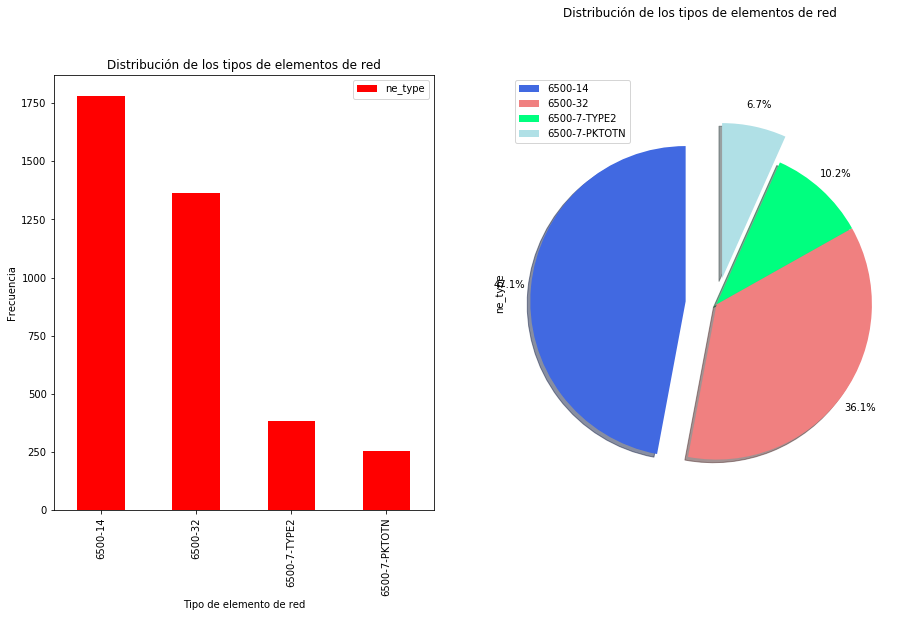

In [14]:
#Revisamos frecuencias:
ne_type=pd.DataFrame(df.ne_type.value_counts())

#Visualización:
fig=plt.figure()
ax0=fig.add_subplot(1,2,1)
ax1=fig.add_subplot(1,2,2)

#Subplot1: Bar chart
ne_type.plot(kind='bar',figsize=(10,6),colormap='rainbow_r',ax=ax0)
ax0.set_xlabel(u'Tipo de elemento de red')
ax0.set_ylabel('Frecuencia')
ax0.set_title(u'Distribución de los tipos de elementos de red')

#Subplot2: Pie chart
#La lista explode debe ser ajustada manualmente contra el número de elementos del catálogo
explode_list=[.2,0,0,.17] #Cada entrada corresponde a un registro del catálogo

color_list=['royalblue','lightcoral','springgreen','powderblue']

ne_type['ne_type'].plot(kind='pie',         
                    figsize=(15,8),
                    autopct='%1.1f%%',
                    startangle=90,
                    shadow=True,
                    labels=None,
                    pctdistance=1.14,
                    colors=color_list,
                               ax=ax1,
                    explode=explode_list)
ax1.set_title(u'Distribución de los tipos de elementos de red',y=1.12)
ax1.axis('equal')
ax1.legend(labels=ne_type.index,loc='upper left')

plt.show()

Parece que el campo ya viene bien homologado. No hace falta hacer limpieza.  
Podrá encontrarse el catálogo en la sección de catálogos.

#### Segundo catálogo: *hardware_version*

Se harán charts para visualizar la distribución de las categorías. Este catálogo será llamado después en el apartado de ***catálogos***.   
Nuestra intención por el momento es simplemente explorar los datos.

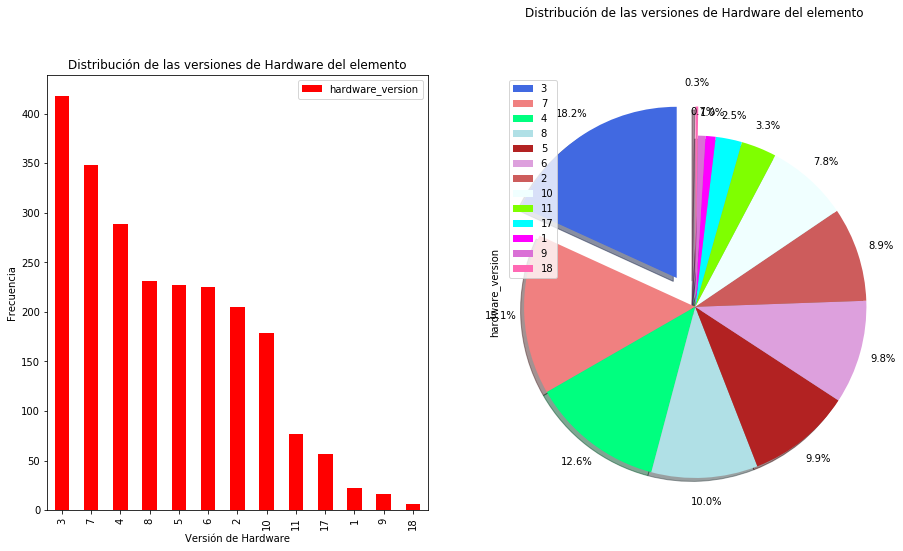

In [15]:
#Revisamos frecuencias:
hardware_version=pd.DataFrame(df.hardware_version.value_counts())

#Visualización:
fig=plt.figure()
ax0=fig.add_subplot(1,2,1)
ax1=fig.add_subplot(1,2,2)

#Subplot1: Bar chart
hardware_version.plot(kind='bar',figsize=(10,6),colormap='rainbow_r',ax=ax0)
ax0.set_xlabel(u'Versión de Hardware')
ax0.set_ylabel('Frecuencia')
ax0.set_title(u'Distribución de las versiones de Hardware del elemento')

#Subplot2: Pie chart
#La lista explode debe ser ajustada manualmente contra el número de elementos del catálogo
explode_list=[.2,0,0,0,0,0,0,0,0,0,0,0,.17] #Cada entrada corresponde a un registro del catálogo

color_list=['royalblue','lightcoral','springgreen','powderblue','firebrick',
            'plum','indianred','azure','chartreuse','aqua','fuchsia','orchid','hotpink']

hardware_version['hardware_version'].plot(kind='pie',         
                    figsize=(15,8),
                    autopct='%1.1f%%',
                    startangle=90,
                    shadow=True,
                    labels=None,
                    pctdistance=1.14,
                    colors=color_list,
                               ax=ax1,
                    explode=explode_list)
ax1.set_title(u'Distribución de las versiones de Hardware del elemento',y=1.12)
ax1.axis('equal')
ax1.legend(labels=hardware_version.index,loc='upper left')

plt.show()

Parece que es un campo limpio, sin embargo, podriamos inferir que deben existir muchas más versiones de Hardware. Por lo tanto, se considerará como un catálogo incompleto hasta el momento. Se podrá revisar en el apartado ***catálogos***.

#### Tercer catálogo: *software_version*

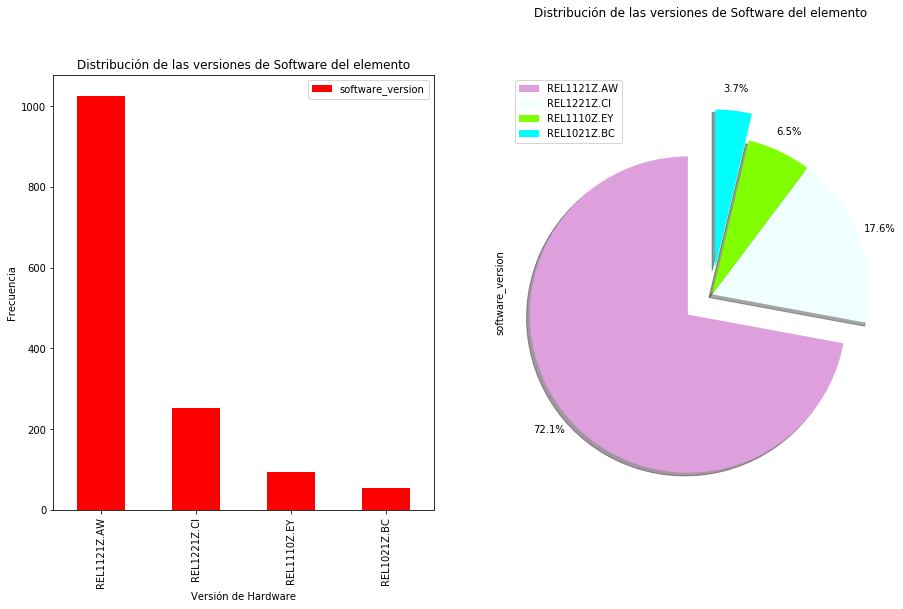

In [16]:
#Revisamos frecuencias:
software_version=pd.DataFrame(df.software_version.value_counts())

#Visualización:
fig=plt.figure()
ax0=fig.add_subplot(1,2,1)
ax1=fig.add_subplot(1,2,2)

#Subplot1: Bar chart
software_version.plot(kind='bar',figsize=(10,6),colormap='rainbow_r',ax=ax0)
ax0.set_xlabel(u'Versión de Hardware')
ax0.set_ylabel('Frecuencia')
ax0.set_title(u'Distribución de las versiones de Software del elemento')

#Subplot2: Pie chart
#La lista explode debe ser ajustada manualmente contra el número de elementos del catálogo
explode_list=[.2,0,0,.17] #Cada entrada corresponde a un registro del catálogo

color_list=['plum','azure','chartreuse','aqua','fuchsia']

software_version['software_version'].plot(kind='pie',         
                    figsize=(15,8),
                    autopct='%1.1f%%',
                    startangle=90,
                    shadow=True,
                    labels=None,
                    pctdistance=1.14,
                    colors=color_list,
                               ax=ax1,
                    explode=explode_list)
ax1.set_title(u'Distribución de las versiones de Software del elemento',y=1.12)
ax1.axis('equal')
ax1.legend(labels=software_version.index,loc='upper left')

plt.show()

Observamos que también son registros limpios. El catálogo será colocado en la sección ***catálogos***.

#### Cuarto catálogo: *operational_status*

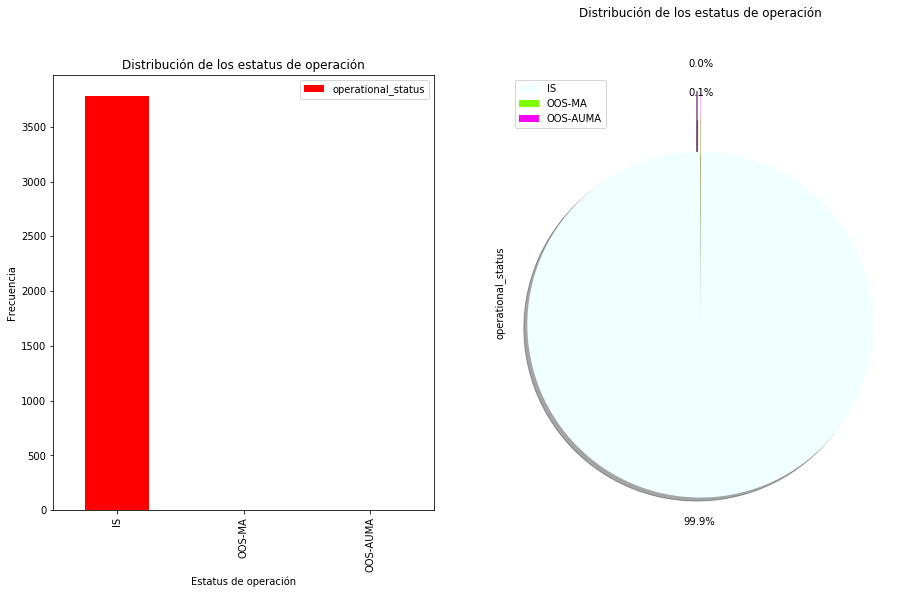

In [17]:
#Revisamos frecuencias:
operational_status=pd.DataFrame(df.operational_status.value_counts())

#Visualización:
fig=plt.figure()
ax0=fig.add_subplot(1,2,1)
ax1=fig.add_subplot(1,2,2)

#Subplot1: Bar chart
operational_status.plot(kind='bar',figsize=(10,6),colormap='rainbow_r',ax=ax0)
ax0.set_xlabel(u'Estatus de operación')
ax0.set_ylabel('Frecuencia')
ax0.set_title(u'Distribución de los estatus de operación')

#Subplot2: Pie chart
#La lista explode debe ser ajustada manualmente contra el número de elementos del catálogo
explode_list=[.2,0,.17] #Cada entrada corresponde a un registro del catálogo

color_list=['azure','chartreuse','fuchsia']

operational_status['operational_status'].plot(kind='pie',         
                    figsize=(15,8),
                    autopct='%1.1f%%',
                    startangle=90,
                    shadow=True,
                    labels=None,
                    pctdistance=1.14,
                    colors=color_list,
                               ax=ax1,
                    explode=explode_list)
ax1.set_title(u'Distribución de los estatus de operación',y=1.12)
ax1.axis('equal')
ax1.legend(labels=operational_status.index,loc='upper left')

plt.show()

Puede notarse la gran diferencia de frecuencia entre estos estatus. Siendo *IS* el estatus más sobresaliente.  
Debido a la distribución que tiene este campo, **no se hará un catálogo**. 

#### Visualización de los datos de trazabilidad: 

In [18]:
pd.DataFrame(df.serie.value_counts()[:15])

,serie
NNTMRT0DT5RK,2
FNSRMYUUF0GUS,1
FNSRMYUUE1BVA,1
NNTMRT0DTL20,1
NNTMRT0C8NGC,1
NNTMRT0LMR9N,1
NNTMRT0DE8PX,1
NNTMRT0DGYPX,1
NNTMRT0D01CP,1
NNTMRT0DTL29,1


Podemos observar que el campo **serie** que usaremos para trazabilidad se enceuntra en buen estado.

### 4. Calidad de los datos
Se documentará la calidad de los datos y analizará las variables que necesitan tratamiento con la ayuda de visualizaciones y tablas.

### Missings Values
Los missings values son los valores faltantes en el conjunto de datos que se refieren a aquellos campos que están vacíos o no tienen valores asignados, estos generalmente ocurren debido a errores de entrada de datos, fallas que ocurren con los procesos de recopilación de datos y, a menudo, al unir varias columnas de diferentes tablas encontramos una condición que conduce a valores faltantes. Existen numerosas formas de tratar los valores perdidos, los más fáciles son reemplazar el valor perdido con la media, la mediana, la moda o un valor constante (llegamos a un valor basado en el conocimiento del dominio) y otra alternativa es eliminar la entrada desde el conjunto de datos en sí.

Calculamos el porcentaje de NA's que tiene la fuente por columna y el porcentaje de los missings.

In [19]:
nas=df[relevantes].isna().sum()
porcentaje_nas=nas/df[relevantes].isna().count()

columnas=list(porcentaje_nas.keys())
counts_nas=list(porcentaje_nas.values)

#Para el siguiente comando, en el parámetro "color":
#Dependiendo el número de columnas se escoge un pallete, este debe ser cargado en la sección de librerías,
#Sólo se añade a la parte from bokeh.palettes import Category20c_20  colocando una ","
#http://docs.bokeh.org/en/1.3.2/docs/reference/palettes.html
#Se recomienda no poner más de 20 columnas. 
source=ColumnDataSource(dict(columnas=columnas, counts_nas=counts_nas, color=Category20c_18))

p=figure(x_range=columnas, plot_height=300, plot_width=850, y_range=(0,1), title='Porcentaje de nas por columna')
p.vbar(x='columnas',top='counts_nas',width=.7, color='color', legend='columnas', source=source)

p.xgrid.grid_line_color = None
p.legend.orientation = "horizontal"
p.legend.location = "top_center"

show(p)
pd.DataFrame(porcentaje_nas*100,columns=['Porcentaje de NAs'])

,Porcentaje de NAs
system_name,0.000000
ne_type,0.000000
component,0.000000
component_subtype,0.000000
clei_code,0.264201
part_number,1.532365
manufacture_date,38.969617
hardware_version,39.233818
firmware_version,100.000000
software_version,62.404227


#### Visualización de datos NOT NULL: 

In [20]:
notmiss=(1-porcentaje_nas)*100

columnas=list(notmiss.keys())
counts_nas=list(notmiss.values)

#Mismo aplica aquí para color
source=ColumnDataSource(dict(columnas=columnas, counts_nas=counts_nas, color=Category20c_18))

p=figure(x_range=columnas, plot_height=300, plot_width=850, y_range=(0,100), 
         title='Porcentaje de not-nulls por columna')
p.vbar(x='columnas',top='counts_nas',width=.5, color='color', legend='columnas', source=source)

p.xgrid.grid_line_color = None
p.legend.orientation = "horizontal"
p.legend.location = "top_center"

show(p)

pd.DataFrame(notmiss,columns=['Porcentaje de Not nulls'])

,Porcentaje de Not nulls
system_name,100.000000
ne_type,100.000000
component,100.000000
component_subtype,100.000000
clei_code,99.735799
part_number,98.467635
manufacture_date,61.030383
hardware_version,60.766182
firmware_version,0.000000
software_version,37.595773


Parece que el campo **serie** se encuentra bastante saludable.   
Podemos ver que los campos **wavelength** y **frecuency**, entre otros varios, son completos nulos. No se podrá hacer ejercicio con variables continuas.

#### 4.2 Data Errors
* **component**: El campo trae muchos datos con formato de fecha, parece ser un problema desde fuente.


### 5. Catálogos.

#### Catálogo de Network Element Type (ne_type):

In [21]:
Catalogo_ne_type=pd.DataFrame(df.ne_type.unique())
Catalogo_ne_type.columns=['ne_type']
Catalogo_ne_type.sort_values(by='ne_type').head(10)

,ne_type
0,6500-14
3,6500-32
2,6500-7-PKTOTN
1,6500-7-TYPE2


#### Catálogo de Hardware version (hardware_version):

In [22]:
Catalogo_hardware_version=pd.DataFrame(df.hardware_version.unique())
Catalogo_hardware_version.columns=['hardware_version']
Catalogo_hardware_version.dropna(inplace=True)
Catalogo_hardware_version.sort_values(by='hardware_version')

,hardware_version
9,1
8,10
10,11
12,17
13,18
6,2
5,3
4,4
1,5
3,6


#### Catálogo de Software version (software_version):

In [23]:
software_version=pd.DataFrame(df.software_version.unique())
software_version.columns=['software_version']
software_version.dropna(inplace=True)
software_version

,software_version
0,REL1121Z.AW
2,REL1110Z.EY
3,REL1221Z.CI
4,REL1021Z.BC


### 6. Preparación de los datos.
Para la preparación de los datos crearemos las reglas de calidad o estándares observados en el apartado anterior de acuerdo a la calidad de datos obtenidos: 

* **De manera general (Aplicado a todos los campos)**: 
    * Se deben remplazar los registros **--** a nulos.
    * Se deberá revisar qué hacer con los campos que se encuentran nulos en su totalidad.
* **series:**
    * Homologar formatos en los casos posibles. 
    * Se marcan como *np.NaN* : campos que contengan:
        * ESPACIOS
        * La palabra BORRADO
        * La palabra VICIBLE
        * La palabra VISIBLE
        * CARACTER ESPECIAL
        * ILEGIBLE
        * INCOMPLETO
        * LONGITUD de caracteres menores a 6



### 7. Métricas KPI.
Se mostrarán los KPIs generados. 

In [58]:
Total_Elementos=df.shape[0]
Total_Elementos

3785

In [59]:
df.replace(np.NaN,'vacio',inplace=True)

#### Total Elementos Trazables

In [67]:
Total_Tr=df.loc[(df.serie_cleaned==0)].shape[0]
Total_Tr

3775

#### Total Elementos NO Trazables

In [68]:
Total_NOTr=Total_Elementos-Total_Tr
Total_NOTr

10

#### Total Elementos Trazables Únicos

In [71]:
Total_Tr_Unic=df['serie'].loc[(df.serie_cleaned!=1)].drop_duplicates().shape[0]
Total_Tr_Unic

3774

In [74]:
len(df['serie'].loc[(df.serie_cleaned!=1)].unique())

3774

#### Total de elementos trazables duplicados

In [75]:
Total_Tr_Dupli=Total_Tr-Total_Tr_Unic
Total_Tr_Dupli

1

In [76]:
#Ajustar el df contra los kpis de la siguiente tabla:

KPIs=pd.DataFrame({'KPI':['Total Elementos','Total Elementos Trazables',
                         'Total NO Trazables','Total Trazables Unicos',
                         'Total Trazables Duplicados'],
                  'Resultado':[Total_Elementos,Total_Tr,Total_NOTr,
                              Total_Tr_Unic,Total_Tr_Dupli]})

KPIs

,KPI,Resultado
0,Total Elementos,3785
1,Total Elementos Trazables,3775
2,Total NO Trazables,10
3,Total Trazables Unicos,3774
4,Total Trazables Duplicados,1


In [27]:
df.to_excel('Universo_Ciena.xlsx')

In [ ]:
sc.stop()